## Imports

In [2]:
import pandas as pd
import numpy as np
import math
import cufflinks as cf
import plotly
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import math
from matplotlib import pyplot as plt
import scipy
from sklearn import model_selection, tree, metrics, ensemble
from bokeh import models, plotting
from bokeh.palettes import Spectral8, Spectral11
import seaborn as sns
# import pycountry as pc
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.models import  ColumnDataSource, Legend, Select
from bokeh.io import output_notebook, show, reset_output
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models import BoxAnnotation
from bokeh.models import Title
from bokeh.layouts import layout
# from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc
from bokeh.models import Range1d
from bokeh.models import LinearAxis
output_notebook()
import bokeh.models as bkm
# import regex as re

Loading BokehJS ...

In [3]:
df = pd.read_csv('C:/Users/Paula/Documents/DTU/Spring_2024/Social_data/project/FinalProject---SocialData24.github.io/Air_Traffic_Passenger_Statistics_20240408.csv')

### Basic Stat

#### Data preprocessing and cleaning

In [4]:
# Delete duplicates
df = df.drop_duplicates()

In [5]:
# Find rows with one or more empty columns
empty_rows = df[df.isnull().any(axis=1)]

# Find columns with empty values
empty_columns = []
for index, row in empty_rows.iterrows():
    empty_columns.extend([col for col in df.columns if pd.isnull(row[col])])

unique_empty_columns = list(set(empty_columns))
print(unique_empty_columns)


['Published Airline IATA Code', 'Operating Airline IATA Code']


Since the only columns that have empty values are these two, we decided to remove them because the information in them is the same as the one in "Operating Airline" and "Published Airline" columns.

In [6]:
df.drop(columns=['Published Airline IATA Code', 'Operating Airline IATA Code'], inplace=True)

In [7]:
# Convert columns to datetime format
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df.drop(columns=['Activity Period'], inplace=True)

In [8]:
# Clean unnecessary columns
df.drop(columns=['data_as_of', 'data_loaded_at'], inplace=True)

In [9]:
df.head()

,Activity Period Start Date,Operating Airline,Published Airline,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,1999-07-01,ATA Airlines,ATA Airlines,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432
1,1999-07-01,ATA Airlines,ATA Airlines,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353
2,1999-07-01,ATA Airlines,ATA Airlines,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518
3,1999-07-01,Aeroflot Russian International Airlines,Aeroflot Russian International Airlines,International,Europe,Deplaned,Other,Terminal 2,D,1324
4,1999-07-01,Aeroflot Russian International Airlines,Aeroflot Russian International Airlines,International,Europe,Enplaned,Other,Terminal 2,D,1198


In [10]:
df.describe()

,Activity Period Start Date,Passenger Count
count,35496,35496.000000
mean,2012-03-28 03:24:05.841784832,27964.436021
min,1999-07-01 00:00:00,0.000000
25%,2006-03-01 00:00:00,4435.000000
50%,2012-08-01 00:00:00,8631.000000
75%,2018-06-01 00:00:00,19882.250000
max,2024-01-01 00:00:00,856501.000000
std,NaN,62675.873220


Total amount of passengers without taking into account what they are doing there

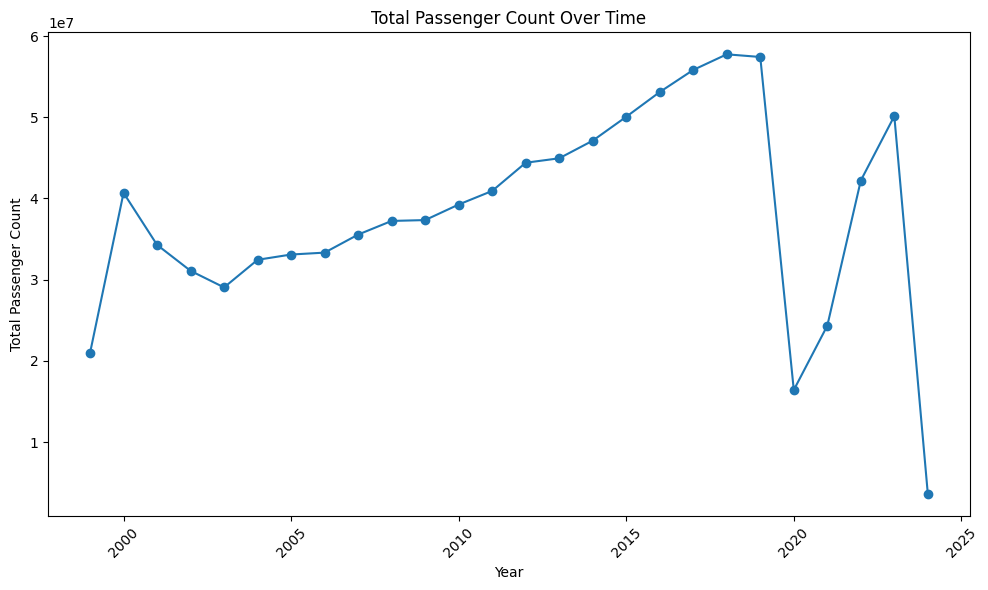

In [11]:
import matplotlib.pyplot as plt

# Group by year and sum 'Passenger Count'
yearly_passenger_count = df.groupby(df['Activity Period Start Date'].dt.year)['Passenger Count'].sum().reset_index()

# Plot the summed 'Passenger Count' for each year
plt.figure(figsize=(10, 6))
plt.plot(yearly_passenger_count['Activity Period Start Date'], yearly_passenger_count['Passenger Count'], marker='o')
plt.title('Total Passenger Count Over Time')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

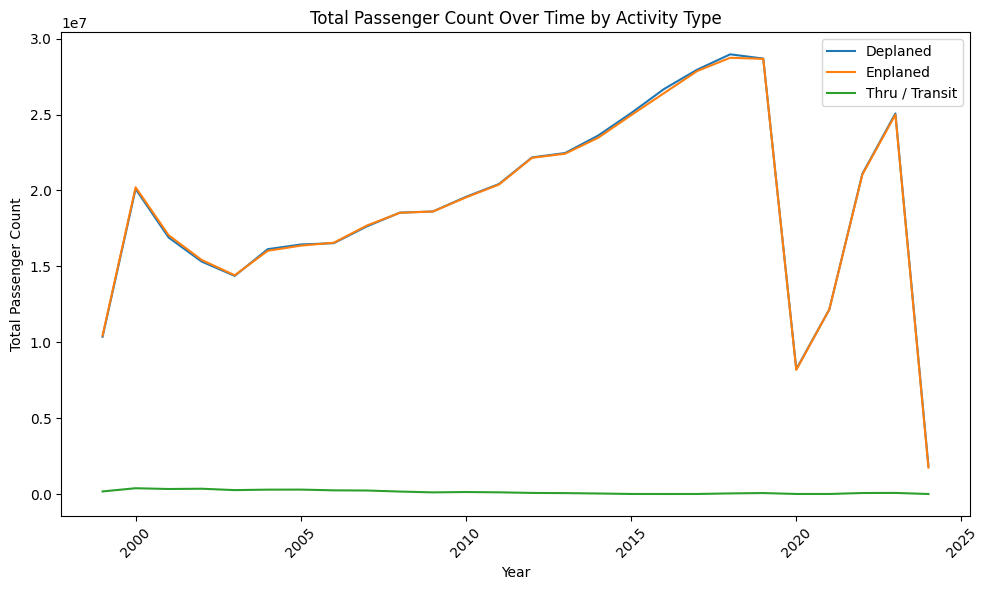

In [12]:
# Group by year and 'Activity Type Code', then sum 'Passenger Count'
grouped_data = df.groupby([df['Activity Period Start Date'].dt.year, 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Plot the summed 'Passenger Count' for each year and activity type
plt.figure(figsize=(10, 6))
for activity_type in grouped_data['Activity Type Code'].unique():
    activity_data = grouped_data[grouped_data['Activity Type Code'] == activity_type]
    plt.plot(activity_data['Activity Period Start Date'], activity_data['Passenger Count'], label=f'{activity_type}')

plt.title('Total Passenger Count Over Time by Activity Type')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Group by year and 'Activity Type Code', then sum 'Passenger Count'
grouped_data = df.groupby([df['Activity Period Start Date'].dt.year, 'Activity Type Code'])['Passenger Count'].sum().reset_index()
grouped_data.head()

,Activity Period Start Date,Activity Type Code,Passenger Count
0,1999,Deplaned,10366082
1,1999,Enplaned,10440197
2,1999,Thru / Transit,176353
3,2000,Deplaned,20095854
4,2000,Enplaned,20208025


In [14]:
# Bokeh libraries
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

# Isolate the data for the Rockets and Warriors
deplaned_data = grouped_data[grouped_data['Activity Type Code'] == 'Deplaned'].drop(columns=['Activity Type Code'])
enplaned_data = grouped_data[grouped_data['Activity Type Code'] == 'Enplaned'].drop(columns=['Activity Type Code'])
transit_data = grouped_data[grouped_data['Activity Type Code'] == 'Thru / Transit'].drop(columns=['Activity Type Code'])

deplaned_cds = ColumnDataSource(deplaned_data)
enplaned_cds = ColumnDataSource(enplaned_data)
transit_cds = ColumnDataSource(transit_data)

# Pivot the DataFrame
passenger_data = grouped_data.pivot(index='Activity Period Start Date', columns='Activity Type Code', values='Passenger Count').reset_index()

# Rename the columns
passenger_data.columns.name = None  # Remove the name of the columns index
passenger_data.columns = ['Year', 'Deplaned', 'Enplaned', 'Transit']

passenger_cds = ColumnDataSource(passenger_data)

# Format the tooltip
tooltips = [
            ('Year','@Year'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@Transit'),
           ]

# Create and configure the figure
fig = figure(
             title='Passengers from San Francisco International Airport',
             x_axis_label='Year', y_axis_label='Passenger Count',
             toolbar_location='below')

# Render the race as step lines with correct legend_label parameter
fig.line('Year', 'Deplaned', 
         color='#CE1141', legend_label='Deplaned', 
         source=passenger_cds)
fig.line('Year', 'Enplaned', 
         color='#006BB6', legend_label='Enplaned', 
         source=passenger_cds)
fig.line('Year', 'Transit',
            color='#FDB927', legend_label='Transit', 
            source=passenger_cds)

# Move the legend to the upper left corner
fig.legend.location = 'top_left'

# Add the HoverTool to the figure
fig.add_tools(HoverTool(tooltips=tooltips))

# Show the plot
show(fig)

In [15]:
# Monthly trend
# Extract month from the date
df['Month'] = df['Activity Period Start Date'].dt.month

# Group by month and sum the passenger count
monthly_passenger_count = df.groupby('Month')['Passenger Count'].mean().reset_index()

# Create a ColumnDataSource
source = ColumnDataSource(monthly_passenger_count)

# Create the figure
p = figure(x_range=(1, 12), title="Monthly Passenger Trends",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Format the tooltip
tooltips = [
    ('Month', '@Month'),
    ("Passenger Count", "@{Passenger Count}{0.00}")
]

# Add a line renderer
p.line(x='Month', y='Passenger Count', line_width=2, source=source)

# Customize the plot
p.circle(x='Month', y='Passenger Count', size=8, source=source, fill_color="white", line_color="firebrick", legend_label="Passenger Count")

# Set the x-axis ticks to display month names
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

# Show the plot
show(p)


In [16]:
import pandas as pd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, CheckboxGroup, CustomJS
from bokeh.layouts import column

# Filter data for the years 2003 and 2020
df_filtered = df[(df['Activity Period Start Date'].dt.year.isin([2003, 2018, 2020, 2023]))]

# Group the data by month and year and sum the passenger counts
df_grouped = df_filtered.groupby([df_filtered['Activity Period Start Date'].dt.month, df_filtered['Activity Period Start Date'].dt.year])['Passenger Count'].sum().unstack()

# Reindex to ensure all months are present even if there's no data for them
df_grouped = df_grouped.reindex(range(1, 13), fill_value=0)

# Rename columns to match the desired format
df_grouped.columns = ['Passenger Count (2003)', 'Passenger Count (2018)', 'Passenger Count (2020)', 'Passenger Count (2023)']

# Rename the index to 'Months'
df_grouped.index.name = 'Months'

source = ColumnDataSource(df_grouped)

p = figure(title="Passenger Counts Across Months", x_axis_label="Months", y_axis_label="Passenger Count",
           x_range=(1, 12))

colors = ['#FF5733', '#006400', '#8B0000', '#008000']

p.line(x='Months', y='Passenger Count (2003)', source=source, legend_label='Passenger Count (2003)', line_width=2, line_color=colors[0])
p.line(x='Months', y='Passenger Count (2018)', source=source, legend_label='Passenger Count (2018)', line_width=2, line_color=colors[1])
p.line(x='Months', y='Passenger Count (2020)', source=source, legend_label='Passenger Count (2020)', line_width=2, line_color=colors[2])
p.line(x='Months', y='Passenger Count (2023)', source=source, legend_label='Passenger Count (2023)', line_width=2, line_color=colors[3])
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Create CheckboxGroup with options to toggle lines
checkbox_group = CheckboxGroup(labels=['Passenger Count (2003)', 'Passenger Count (2018)', 'Passenger Count (2020)', 'Passenger Count (2023)'],
                               active=[0, 1, 2, 3])

# Add CustomJS callback to update visibility of lines based on checkbox selection
checkbox_callback = CustomJS(code="""
    var selected_indices = cb_obj.active;
    for (var i = 0; i < cb_obj.labels.length; i++) {
        var line = plot_instance.renderers[i];
        if (selected_indices.includes(i)) {
            line.visible = true;
        } else {
            line.visible = false;
        }
    }
""", args={'plot_instance': p})

checkbox_group.js_on_change('active', checkbox_callback)

# Layout the plot and checkbox group
layout = column(p, checkbox_group)

show(layout)

In [17]:
import pandas as pd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, CheckboxGroup, CustomJS
from bokeh.layouts import column

# Filter data for the years 2003 and 2020
df_filtered = df[(df['Activity Period Start Date'].dt.year.isin([2003, 2018, 2020, 2023]))]

# Group the data by month and year and sum the passenger counts
df_grouped = df_filtered.groupby([df_filtered['Activity Period Start Date'].dt.month, df_filtered['Activity Period Start Date'].dt.year])['Passenger Count'].sum().unstack()

# Reindex to ensure all months are present even if there's no data for them
df_grouped = df_grouped.reindex(range(1, 13), fill_value=0)

# Rename columns to match the desired format
df_grouped.columns = ['Passenger Count (2003)', 'Passenger Count (2018)', 'Passenger Count (2020)', 'Passenger Count (2023)']

# Rename the index to 'Months'
df_grouped.index.name = 'Months'

source = ColumnDataSource(df_grouped)

p = figure(title="Passenger Counts Across Months", x_axis_label="Months", y_axis_label="Passenger Count",
           x_range=(1, 12))

colors = ['#FF5733', '#006400', '#8B0000', '#008000']

p.varea(x='Months', y1='Passenger Count (2003)', y2=0, source=source, legend_label='Passenger Count (2003)', fill_alpha=0.5, fill_color=colors[0])
p.varea(x='Months', y1='Passenger Count (2018)', y2=0, source=source, legend_label='Passenger Count (2018)', fill_alpha=0.5, fill_color=colors[1])
p.varea(x='Months', y1='Passenger Count (2020)', y2=0, source=source, legend_label='Passenger Count (2020)', fill_alpha=0.5, fill_color=colors[2])
p.varea(x='Months', y1='Passenger Count (2023)', y2=0, source=source, legend_label='Passenger Count (2023)', fill_alpha=0.5, fill_color=colors[3])

p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Create CheckboxGroup with options to toggle lines
checkbox_group = CheckboxGroup(labels=['Passenger Count (2003)', 'Passenger Count (2018)', 'Passenger Count (2020)', 'Passenger Count (2023)'],
                               active=[0, 1, 2, 3])

# Add CustomJS callback to update visibility of lines based on checkbox selection
checkbox_callback = CustomJS(code="""
    var selected_indices = cb_obj.active;
    for (var i = 0; i < cb_obj.labels.length; i++) {
        var line = plot_instance.renderers[i];
        if (selected_indices.includes(i)) {
            line.visible = true;
        } else {
            line.visible = false;
        }
    }
""", args={'plot_instance': p})

checkbox_group.js_on_change('active', checkbox_callback)

# Layout the plot and checkbox group
layout = column(p, checkbox_group)

show(layout)

In [18]:
# Group by month and activity type and sum the passenger count
monthly_activity_count = df.groupby(['Month', 'Activity Type Code'])['Passenger Count'].mean().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define colors for each activity type
fill_colors = ["#c9d9d3", "#718dbf", "#e84d60"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_left"
p.legend.label_text_font_size = "8pt"

# Show the plot
show(p)

In [32]:
# Same as before but specifically in covid year
# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2020]

# Group by month and activity type and sum the passenger count
monthly_activity_count = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2020)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define colors for each activity type
fill_colors = ["#c9d9d3", "#718dbf", "#e84d60"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

# Show the plot
show(p)

In [33]:
# Same as before but specifically in covid year
# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2021]

# Group by month and activity type and sum the passenger count
monthly_activity_count = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2021)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define colors for each activity type
fill_colors = ["#c9d9d3", "#718dbf", "#e84d60"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

# Show the plot
show(p)